# CMIST Hiring Exercise - ML+CV Engineer

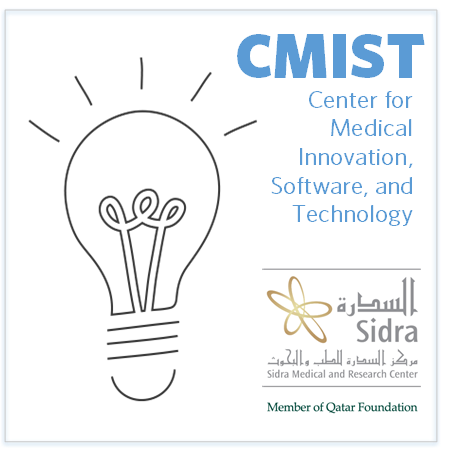

## Aim of the Project: 

The aim of this project is to detect the vehicles in a dash camera video. The implementation of the project is in the file vehicle_detection.ipynb. This implementation is able to achieve 21FPS without batching processing. 

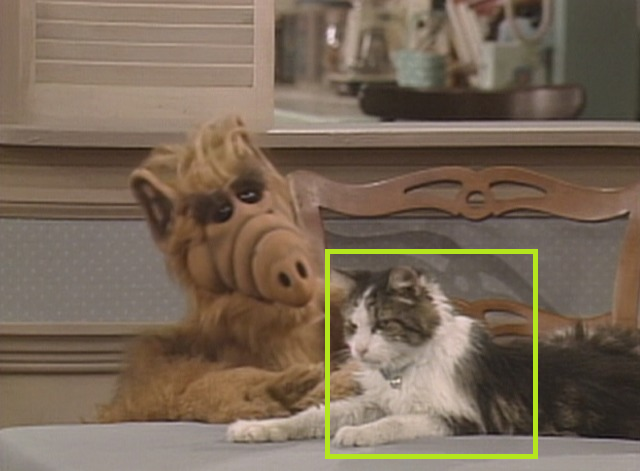


## Algorithm Used: You Only Look Once (YOLO)

### Brief Intro

For this project I decided to go for a deep learning approach rather than the classic Computer Vision techniques. Several important papers on object detection using deep convolutional networks have been published the last few years. More specifically, Faster R-CNN, YOLO and Single Shot MultiBox Detector are the present state-of-the-art in using CNN for real-time object detection.

Traditional, computer vision technique based, approaches for object detection systems repurpose classifiers to perform detection. To detect an object, these systems take a classifier for that object and evaluate it at various locations and scales in a test image. Systems like deformable parts models (DPM) use a sliding window approach where the classifier is run at evenly spaced locations over the entire image.
Other approaaches like R-CNN use region proposal methods to first generate potential bounding boxes in an image and then run a classifier on these proposed boxes. After classification, post-processing is used to refine the bounding boxes, eliminate duplicate detections, and rescore the boxes based on other objects in the scene. These complex pipelines are slow and hard to optimize because each individual component must be trained separately.
YOLO reframes object detection as a single regression problem, straight from image pixels to bounding box coordinates and class probabilities. A single convolutional network simultaneously predicts multiple bounding boxes and class probabilities for those boxes. YOLO trains on full images and directly optimizes detection performance.
In this project we will implement tiny-YOLO v1. Full details of the network, training and implementation are available in the paper - http://arxiv.org/abs/1506.02640

## Implementation

YOLO divides the input image into an SxS grid. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. Each grid cell predicts B bounding boxes and confidence scores for those boxes.
Confidence is defined as (Probability that the grid cell contains an object) multiplied by (Intersection over union of predicted bounding box over the ground truth). Or
Confidence = Pr(Object) x IOU_truth_pred.(1)

If no object exists in that cell, the confidence scores should be zero. Otherwise we want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth.
Each bounding box consists of 5 predictions:
    1.x
    2.y
    3.w
    4.h
    5.confidence
    
    
The (x; y) coordinates represent the center of the box relative to the bounds of the grid cell. The width and height are predicted relative to the whole image. Finally the confidence prediction represents the IOU between the predicted box and any ground truth box.
Each grid cell also predicts C conditional class probabilities, Pr(ClassijObject). These probabilities are conditioned on the grid cell containing an object. We only predict one set of class probabilities per grid cell, regardless of the number of boxes B.
At test time we multiply the conditional class probabilities and the individual box confidence predictions,
Pr(Class|Object) x Pr(Object) x IOU_truth_pred = Pr(Class) x IOU_truth_pred                    (2)

which gives us class-specific confidence scores for each box. These scores encode both the probability of that class appearing in the box and how well the predicted box fits the object.
So at test time, the final output vector for each image is a S x S x (B x 5 + C) length vector

## The Model

### Architecture

The model architecture consists of 9 convolutional layers, followed by 3 fully connected layers. Each convolutional layer is followed by a Leaky RELU activation function, with alpha of 0.1. The first 6 convolutional layers also have a 2x2 max pooling layers.

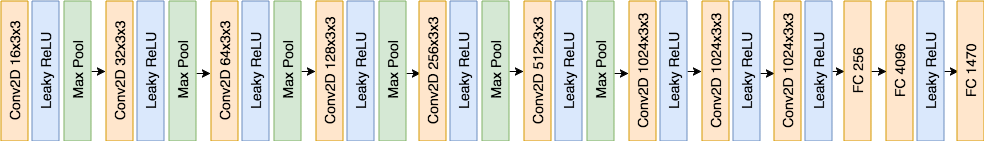

In [146]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Target_path='/test_images/'

In [147]:
# Pre trained weights require this ordering
keras.backend.set_image_dim_ordering('th')

def get_model():
    model = Sequential()
    
    # Layer 1
    model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 3
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 4
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 5
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 6
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 7
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 8
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 9
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Flatten())
    
    # Layer 10
    model.add(Dense(256))
    
    # Layer 11
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 12
    model.add(Dense(1470))
    
    return model

## Pre-processing
Images are resized to a 448x448 image. Each image pixel is normalized to have values between -1 and 1. I use simple min-max normalization to achieve this.

In [148]:
# Preprocessing

def crop_and_resize(image):
    cropped = image[:,:,:]
    return cv2.resize(cropped, (448,448))

def normalize(image):
    normalized = 2.0*image/255.0 - 1
    return normalized

def preprocess(image):
    cropped = crop_and_resize(image)
    normalized = normalize(cropped)
    # The model works on (channel, height, width) ordering of dimensions
    transposed = np.transpose(normalized, (2,0,1))
    return transposed

## Output
The model was trained on PASCAL VOC dataset. We use S = 7, B = 2. PASCAL VOC has 20 labelled classes so C = 20. So our final prediction, for each input image, is:
output tensor length = S x S x (B x 5 + C)
output tensor length = 7 x 7 x (2x5 + 20)
output tensor length = 1470.

The structure of the 1470 length tensor is as follows:
First 980 values correspons to probabilities for each of the 20 classes for each grid cell. These probabilities are conditioned on objects being present in each grid cell.
The next 98 values are confidence scores for 2 bounding boxes predicted by each grid cells.
The next 392 values are co-ordinates (x, y, w, h) for 2 bounding boxes per grid cell.
## Training
I have used pre-trained weights for this project. Training is done in 2 parts
Part 1: Training for classification
This model was trained on ImageNet 1000-class classification dataset. For this we take the first 6 convolutional layers followed by a followed by a fully connected layer.
Part 2: Training for detection
The model is then converted for detection. This is done by adding 3 convolutional layers and 3 fully connected layers. The modified model is then trained on PASCAL VOC detection dataset.
The pre-trained weights for this model (180 MB) are available here.

## Post Processing
As you can see in the above image, each input image is divided into an S x S grid and for each grid cell, our model predicts B bounding boxes and C confidence scores. There is a fair amount of post-processing involved to arrive at the final bounding boxes based on the model's predictions.
### Class score threshold
We reject output from grid cells below a certain threshold (0.2) of class scores (equation 2), computed at test time.
Reject overlapping (duplicate) bounding boxes
If multiple bounding boxes, for each class overlap and have an IOU of more than 0.4 (intersecting area is 40% of union area of boxes), then we keep the box with the highest class score and reject the other box(es).
### Drawing the bounding boxes
The predictions (x, y) for each bounding box are relative to the bounds of the grid cell and (w, h) are relative to the whole image. To compute the final bounding box coodinates we have to multiply w & h with the width & height of the portion of the image used as input for the network.

In [286]:


class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()
        
def overlap(x1, w1, x2, w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


def box_intersection(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection area of the 2 boxes
    """
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    area = w * h
    return area


def box_union(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Area under the union of the 2 boxes
    """
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i
    return u


def box_iou(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection over union, which is ratio of intersection area to union area of the 2 boxes
    """
    return box_intersection(a, b) / box_union(a, b)



def yolo_output_to_cat_boxes(yolo_output, threshold=0.2, sqrt=1.8, C=20, B=2, S=7):

    # Position for class 'cat' in the VOC dataset classes
    cat_class_number = 7

    boxes = []
    SS = S*S  # number of grid cells
    prob_size = SS*C  # class probabilities
    conf_size = SS*B  # confidences for each grid cell

    probabilities = yolo_output[0:prob_size]
    confidence_scores = yolo_output[prob_size: (prob_size + conf_size)]
    cords = yolo_output[(prob_size + conf_size):]

    # Reshape the arrays so that its easier to loop over them
    probabilities = probabilities.reshape((SS, C))
    confs = confidence_scores.reshape((SS, B))
    cords = cords.reshape((SS, B, 4))

    for grid in range(SS):
        for b in range(B):
            bx = Box()

            bx.c = confs[grid, b]

            # bounding box xand y coordinates are offsets of a particular grid cell location,
            # so they are also bounded between 0 and 1.
            # convert them absolute locations relative to the image size
            bx.x = (cords[grid, b, 0] + grid % S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S


            bx.w = cords[grid, b, 2] ** sqrt
            bx.h = cords[grid, b, 3] ** sqrt

            # multiply confidence scores with class probabilities to get class sepcific confidence scores
            p = probabilities[grid, :] * bx.c

            # Check if the confidence score for class 'car' is greater than the threshold
            if p[cat_class_number] >= threshold:
                bx.prob = p[cat_class_number]
                boxes.append(bx)

    # combine boxes that are overlap

    # sort the boxes by confidence score, in the descending order
    boxes.sort(key=lambda b: b.prob, reverse=True)


    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0:
            continue

        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]

            # If boxes have more than 40% overlap then retain the box with the highest confidence score
            if box_iou(boxi, boxj) >= 0.4:
                boxes[j].prob = 0

    boxes = [b for b in boxes if b.prob > 0]

    return boxes


def draw_boxes(boxes,im, crop_dim):
    imgcv1 = im.copy()
    [xmin, xmax] = crop_dim[0]
    [ymin, ymax] = crop_dim[1]
    
    height, width, _ = imgcv1.shape
    for b in boxes:
        w = xmax - xmin
        h = ymax - ymin

        left  = int ((b.x - b.w/2.) * w) + xmin
        right = int ((b.x + b.w/2.) * w) + xmin
        top   = int ((b.y - b.h/2.) * h) + ymin
        bot   = int ((b.y + b.h/2.) * h) + ymin

        if left  < 0:
            left = 0
        if right > width - 1:
            right = width - 1
        if top < 0:
            top = 0
        if bot>height - 1: 
            bot = height - 1
        
        thick = 5 #int((height + width // 150))
        
        cv2.rectangle(imgcv1, (left, top), (right, bot), (255,0,0), thick)

    return imgcv1

In [287]:
import numpy as np
import cv2


def load_weights(model, yolo_weight_file):
    data = np.fromfile(yolo_weight_file, np.float32)
    data = data[4:]

    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape, bshape = shape
            bia = data[index:index + np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index + np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker, bia])


## Load weight from pretrained weights for yolo

The weight file can be downloaded from https://pjreddie.com/darknet/yolo/

In [288]:
model = get_model()
load_weights(model,'yolo-tiny.weights')

### Handling different file formats 

The test set contains files of different formats... Converting to one standard format.

#### Apply the model to a test image

In [289]:
test_path= 'C:\Python 3.5\Scripts\Cat-master'

from PIL import Image
in_file = 'test (26).jpg'
filename, file_extension = os.path.splitext(in_file)


import os

out_file = filename +".jpg"
if in_file != outfile:
    try:
      Image.open(in_file).save(out_file)
    except IOError:
      print("cannot convert",+infile)
    
test_image = mpimg.imread(out_file)
pre_processed = preprocess(test_image)
batch = np.expand_dims(pre_processed, axis=0)
batch_output = model.predict(batch)
print(batch_output.shape)

(1, 1470)


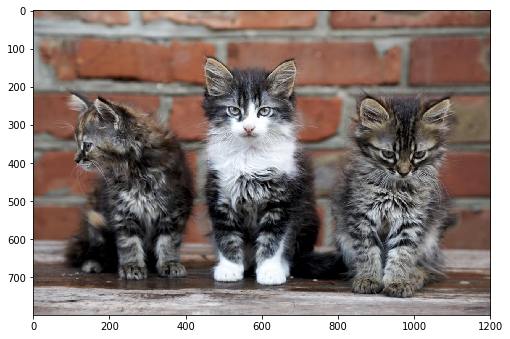

In [290]:
plt.imshow(test_image)

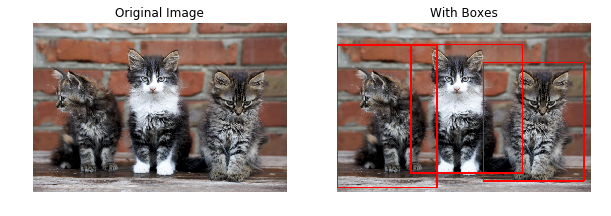

In [291]:
boxes = yolo_output_to_cat_boxes(batch_output[0], threshold=0.2)
cv2.resize(test_image, (448,448))
final = draw_boxes(boxes, test_image, ((0,test_image.shape[1]),(0,test_image.shape[0])))

plt.rcParams['figure.figsize'] = (10, 5.6)
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(final)
plt.axis('off')
plt.title("With Boxes")

In [292]:
# Final pipeline
def pipeline(image):
    pre_processed = preprocess(image)
    batch = np.expand_dims(pre_processed, axis=0)
    batch_output = model.predict(batch)
    boxes = yolo_output_to_cat_boxes(batch_output[0], threshold=0.2)
    image = cv2.resize(image, (448,448))
    final = draw_boxes(boxes,image, ((1,image.shape[1]),(1,image.shape[0])))
    return final

In [300]:
filenames = glob.glob("test_images/*.*")
print(1)
num_files = len(filenames)


for i in range(0,num_files):
        print ('file:',filenames[i])
        filename, file_extension = os.path.splitext(filenames[i])
        out_file = filenames[i]
        if (file_extension == '.png' or file_extension == '.jpeg') :
          try:
             out_file = filename +"_.jpg"
             Image.open(filenames[i]).save(out_file)
          except IOError:
              print("cannot convert",+infile)
        image = mpimg.imread(out_file)
        image = cv2.resize(image, (448,448))
        final = pipeline(image)
        out_file = out_file.replace('test_images','output_images')
        print ('Out file', out_file)
        mpimg.imsave(out_file, final)
    
   


1
file: test_images\test (1).jpeg
Out file output_images\test (1)_.jpg
file: test_images\test (1).jpg
Out file output_images\test (1).jpg
file: test_images\test (1).png
Out file output_images\test (1)_.jpg
file: test_images\test (1)_.jpg
Out file output_images\test (1)_.jpg
file: test_images\test (10).jpg
Out file output_images\test (10).jpg
file: test_images\test (100).jpg
Out file output_images\test (100).jpg
file: test_images\test (101).jpg


KeyboardInterrupt: 

## Areas of Improvement

### Simpler Network
The cat detection is clearly far from perfect as it is now! There are several parts of the pipeline which could be improved. I have used a pre-train YOLO v1 network. This network is designed to detect 20 object classes. We could design and train a smaller network to work only on cats. This will reduce time required for forward pass.
### Better Hardware
This code was run on a i5 8GB laptop, without GPU support. If run on a faster machine with GPU support the frame rate can be increased.